In [3]:
# Loading required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE

import gc
import pickle as pkl

%matplotlib inline
sns.set(style='whitegrid', palette='inferno', font_scale=1.5)

import warnings
warnings.filterwarnings(action="ignore")

In [9]:
loan_data = pd.read_csv('RawData/processed_loan_origin.csv')

In [10]:
loan_data['UPB'] = np.log1p(loan_data['UPB'])
loan_data['target'] = loan_data['target'].map({'Moderate-Risk':1,'No-Risk':0,'High-Risk':1})
cols = ['Channel','Origin_Year', 'Seller', 'Interest_Rate', 'UPB','LTV', 'Num_Borrowers', 'First_Time_Buyer',
        'Loan_Purpose', 'LOAN AGE', 'FICO_bins', 'Term_bins', 'target']

In [11]:
risk_data = loan_data[cols]
risk_data = pd.get_dummies(risk_data)

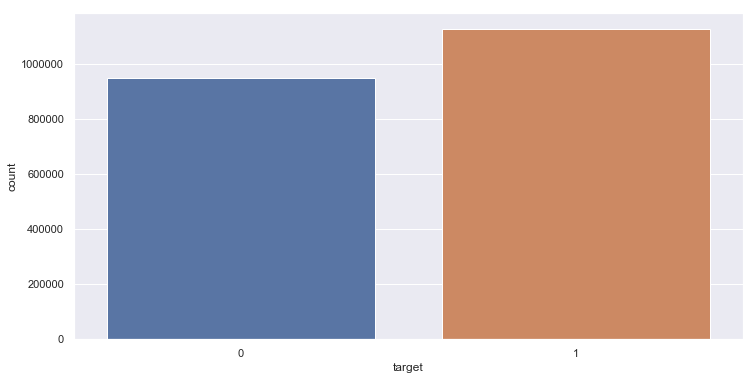

In [12]:
sns.set(rc={'figure.figsize':(12,6)})
sns.countplot(risk_data['target'])

In [13]:
X = risk_data.drop(['target'], axis = 1)

y = risk_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1210)

In [14]:
def score(model, test = X_test, y_true = y_test):
    
    pred = model.predict(test)

    print('Average precision-recall score RF:\t', round(average_precision_score(y_true, pred),4)*100)
    print()
    print("Cohen's Kappa Score:\t",round(cohen_kappa_score(y_true,pred),4)*100)
    print()
    print("R-Squared Score:\t",round(r2_score(y_true,pred),4)*100)
    print()
    print("Area Under ROC Curve:\t",round(roc_auc_score(y_true,pred),4)*100)
    print()
    print(classification_report(y_true,pred)) 
    print()
    print(confusion_matrix(y_true,pred)) 
    
    fpr_rf, tpr_rf, _ = roc_curve(y_true, pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.figure(figsize=(8,8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.step(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))
    #plt.fill_between(fpr_rf, tpr_rf, step='post', alpha=0.2, color='b')


    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
def score_mclass(model, test = X_test, y_true = y_test):
    
    pred = model.predict(test)

    print("R-Squared Score:\t",round(r2_score(y_true,pred),4)*100)
    print()
    print(classification_report(y_true,pred))
    print()
    feat_imp = pd.DataFrame(model.feature_importances_,index=X.columns,columns=['Feature Importance'])
    top_feat = feat_imp.sort_values('Feature Importance',ascending=False).index[0:10]
    print("Top 10 Features:\n",top_feat)

In [15]:
dtree = DecisionTreeClassifier()

dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Average precision-recall score RF:	 96.39999999999999

Cohen's Kappa Score:	 94.73

R-Squared Score:	 89.47

Area Under ROC Curve:	 97.34

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    284932
           1       0.97      0.98      0.98    337634

    accuracy                           0.97    622566
   macro avg       0.97      0.97      0.97    622566
weighted avg       0.97      0.97      0.97    622566


[[275828   9104]
 [  7170 330464]]


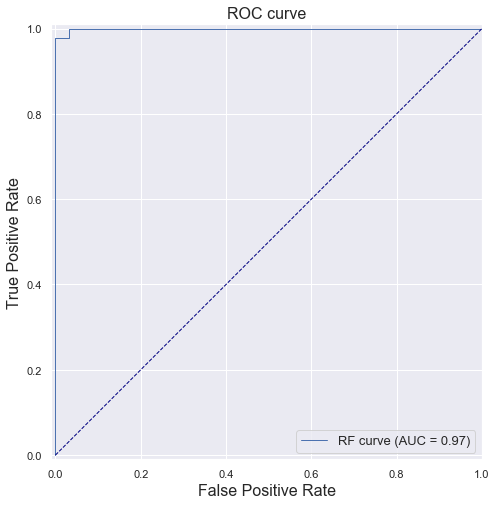

In [16]:
score(dtree)

In [17]:
rf = RandomForestClassifier(class_weight={0:2,1:1})

rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 2, 1: 1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Average precision-recall score RF:	 98.59

Cohen's Kappa Score:	 97.08

R-Squared Score:	 94.15

Area Under ROC Curve:	 98.63

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    284932
           1       1.00      0.98      0.99    337634

    accuracy                           0.99    622566
   macro avg       0.98      0.99      0.99    622566
weighted avg       0.99      0.99      0.99    622566


[[283775   1157]
 [  7883 329751]]


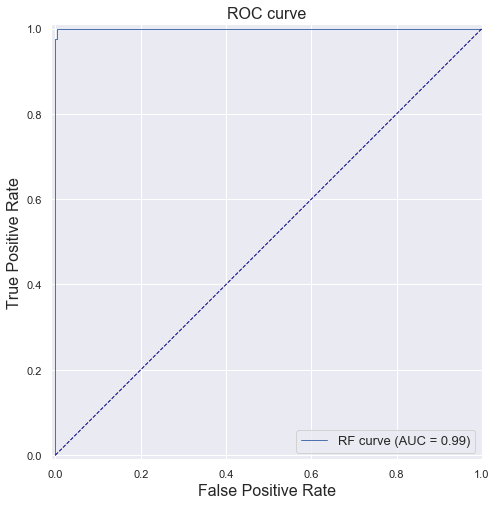

In [18]:
score(rf)

In [21]:
with open('rf_model.pkl','wb') as model:
    pkl.dump(rf,model)

In [146]:
with open('lgbm_model.pkl','rb') as model:
    lgbm = pkl.load(model)

In [28]:
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml

In [23]:
pl = PMMLPipeline([('clf', RandomForestClassifier(class_weight={0:2,1:1}))])

pl.fit(X_train,y_train)

PMMLPipeline(steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight={0: 2, 1: 1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False))])

In [32]:
pl.target_field="target"
pl.active_fields=np.array(X_train.columns)

In [34]:
sklearn2pmml(pl, 'RandomForest.pmml', with_repr=True)